In [1]:
# ! mkdir data
# ! mkdir data/palm_tree
# ! gsutil cp -r gs://nclinton-misc/high-res-patches data/palm_tree

In [2]:
STAGING_BUCKET = "ivanmkc-palm-data"

# ! gsutil mb gs://{STAGING_BUCKET}

In [3]:
import tensorflow as tf

LABELS_SIZE = 8054

# Keys listed in go/sat-seg-keys.
palette = [
'000000', # 0 No Data
'a6cee3', # 1 Water
'1f78b4', # 2 Opaque Clouds
'b2df8a', # 3 Trees and Shrubs
'33a02c', # 4 Built surface
'fb9a99', # 5 Bridges and dams
'e31a1c', # 6 Grass
'fdbf6f', # 7 Plant/Ground Mix
'ff7f00', # 8 Crops (other than Palm Plantations)
'cab2d6', # 9 Palm Plantations
'6a3d9a', # 10 Flooded Vegetation
'ffff99', # 11 Bare Ground and Sand
'b15928', # 12 Snow and Ice
'000000'  # 13 Unknown
]

NUM_CLASSES = len(palette)

# Each tile is from 30cm WV3 satellite imagery, is 1024px x 1024px and is labelled twice.
SCALE = 0.3
PATCH_SIZE = 512

BANDS = ['R', 'G', 'B']
LABELS_NAMES = ['label_1', 'label_2']
FEATURES = BANDS + LABELS_NAMES

IMG_SIZE = [PATCH_SIZE, PATCH_SIZE, len(BANDS)]

# Specify the size and shape of patches expected by the model.
KERNEL_SHAPE = [PATCH_SIZE, PATCH_SIZE]
COLUMNS = [
  tf.io.FixedLenFeature(shape=KERNEL_SHAPE, dtype=tf.float32) for k in FEATURES
]
FEATURES_DICT = dict(zip(FEATURES, COLUMNS))

def parse_tfrecord(example_proto):
  """The parsing function.
  Read a serialized example into the structure defined by FEATURES_DICT.
  Args:
    example_proto: a serialized Example.
  Returns:
    A dictionary of tensors, keyed by feature name.
  """
  return tf.io.parse_single_example(example_proto, FEATURES_DICT)


def to_tuple(tensor):
  """Function to convert a tensor to a tuple of (inputs, outputs).
  Args:
    tensor: A stacked tensor, with label last.
  Returns:
    A tuple of (inputs, outputs).
  """
  return tensor[:,:,:len(BANDS)], tensor[:,:,len(BANDS):]


def flatten_patches(inputs):
  """Function to convert a dictionary of tensors to two stacked 
    tensors in HWC shape.
  Args:
    inputs: A dictionary of tensors, keyed by feature name.
  Returns:
    A tf.data.Dataset with two examaples in it.
  """
  inputsList = [inputs.get(key) for key in BANDS]
  label_1 = [inputs.get(LABELS_NAMES[0])]
  label_2 = [inputs.get(LABELS_NAMES[1])]
  stack1 = tf.stack(inputsList + label_1, axis=0)
  stack2 = tf.stack(inputsList + label_2, axis=0)
  # Convert from CHW to HWC
  return tf.data.Dataset.from_tensor_slices([
    tf.transpose(stack1, [1, 2, 0]),
    tf.transpose(stack2, [1, 2, 0]),
  ])
  
def get_dataset(glob):
  """"""
  dataset = tf.data.TFRecordDataset(glob, compression_type='GZIP')
  dataset = dataset.map(parse_tfrecord, num_parallel_calls=5)
  dataset = dataset.flat_map(flatten_patches)
  dataset = dataset.map(to_tuple, num_parallel_calls=5)
  return dataset


def get_datasets(pattern):
    """"""
    glob = tf.io.gfile.glob(pattern)
    size = len(glob)
    train_size = int(0.8*size)
    shuffled = tf.random.shuffle(glob)
    train_files = shuffled[:train_size]
    test_files = shuffled[train_size:]
    training = get_dataset(train_files)
    # training = training.shuffle(2048).repeat()
    testing = get_dataset(test_files)
    # testing = testing.batch(1)
    return training, testing

In [4]:
TRAINING_BASE = 'labels_'
FOLDER = 'high-res-patches'
BUCKET = 'ivanmkc-palm-data'

pattern = 'gs://' + BUCKET + '/' + FOLDER + '/' + TRAINING_BASE + '*'

training, testing = get_datasets(pattern)


2022-04-28 17:10:48.190196: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [5]:
import tensorflow_datasets as tfds

for i, (image, mask) in enumerate(tfds.as_numpy(training.take(1))):
    print(image.shape)
    print(mask.shape)

(512, 512, 3)
(512, 512, 1)


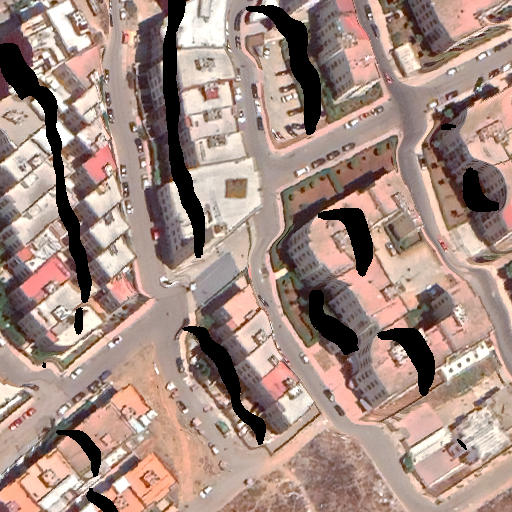

In [6]:
from PIL import Image
import numpy as np

image_object = Image.fromarray(np.uint8(image)).convert('RGB')
display(image_object)


In [7]:
# mask_rgb = np.zeros((mask.shape[0], mask.shape[1], 3))

# mask_rgb.shape

# mask_rgb[mask_rgb == 0] = [1, 2, 3]

In [8]:
# bmask_rgb[mask_rgb == 0]
import matplotlib.pyplot as plt

def display_image_mask(image, mask):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask']

  display_list = [image, mask]

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

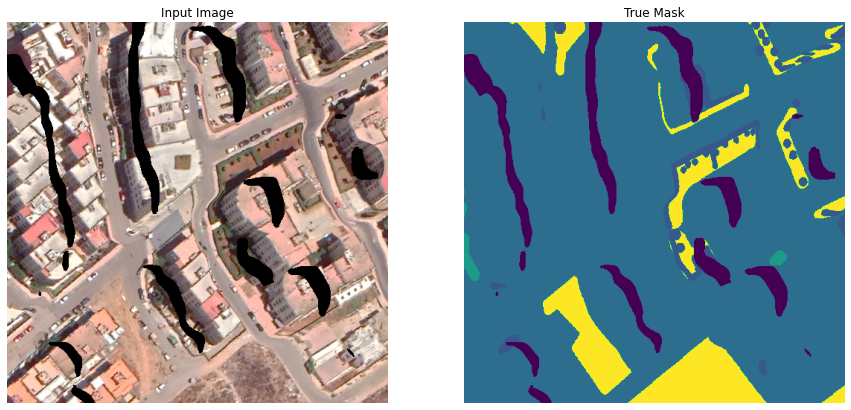

In [9]:
display_image_mask(image, mask)

In [10]:
from google.cloud import storage

def upload_blob(bucket_name, source_file_name, destination_blob_name):
    """Uploads a file to the bucket."""

    storage_client = storage.Client()
    bucket = storage_client.bucket(bucket_name)
    blob = bucket.blob(destination_blob_name)

    blob.upload_from_filename(source_file_name)

    destination_file_name = os.path.join(bucket_name, destination_blob_name)

    return destination_file_name
    # destination = os.path.join("/bigstore", bucket_name, destination_blob_name)
    # ! fileutil_bs cp -f {source_file_name} {destination}

In [11]:
from typing import Dict
import os
import hashlib

class ImageSegmentationConverter:
  def __init__(self, number_to_label_map: Dict[int, str]):
    import seaborn as sns

    self.number_to_label_map = number_to_label_map
    
    colors = [np.array(list(color))*255 for color in sns.color_palette(None, len(self.number_to_label_map))]
    self.number_to_color_map = {number: color for number, color in zip(number_to_label_map.keys(), colors)}
    
    self.file_to_checksum_map: Dict[str, str] = {}
    
  def reset_duplication_checks(self):
    self.file_to_checksum_map.clear()

  # See https://docs.google.com/document/d/1rwdR0IKPCIU5Lw2lsuiN_s-FH6NCBByUtuBqZyBG9o8/edit#bookmark=id.u2hwzu97nn4o
  # See https://source.corp.google.com/piper///depot/google3/googlex/agility/agdata/ml/semantic_segmentation/data_preprocessor.py;bpv=1;bpt=1;rcl=388684767;l=148?gsn=decode_img_mask_from_tfexample&gs=kythe%3A%2F%2Fgoogle3%3Flang%3Dpython%3Fpath%3Dgooglex%2Fagility%2Fagdata%2Fml%2Fsemantic_segmentation%2Fdata_preprocessor.py%23module.Preprocessor.decode_img_mask_from_tfexample
  def convert_example_to_dict(self, image_np: np.ndarray, mask_np: np.ndarray, name: str, output_gcs_bucket: str, output_gcs_blob_folder: str, train_val_test: str, show_image: bool = True) -> Dict:
    # Create image
    image = tf.keras.utils.array_to_img(image_np)

    # Write to temp filea
    temp_filename = "temp.png"
    image.save(temp_filename, format="png")

    # Create image mask matrix
    image_mask_matrix = mask_np.reshape(mask_np.shape[:2])
    # Rewrite as RGB
    image_mask_matrix_rgb = np.zeros((image_mask_matrix.shape[0], image_mask_matrix.shape[1], 3), dtype=np.uint8)
    numbers_used = set()
    for number in self.number_to_label_map.keys():
      color = self.number_to_color_map[number]
      if len(image_mask_matrix_rgb[..., :][image_mask_matrix==number]) > 0:
        image_mask_matrix_rgb[..., :][image_mask_matrix==number] = color
        numbers_used.add(number)
        
    # Convert back to image
    image_mask_rgb = Image.fromarray(image_mask_matrix_rgb)
    mask_filename = "mask.png"
    image_mask_rgb.save(mask_filename, format="png")

    # if show_image:      
    #   image_mask = Image.fromarray(np.uint8(image_mask_matrix>0)*255, mode="L")
      
    #   image = Image.open(BytesIO(image_encoded))
    #   image.paste(image_mask_rgb, (0, 0), image_mask)
    #   imshow(image)

    # Upload image to GCS
    output_gcs_blob_file = os.path.join(output_gcs_blob_folder, f"{name}.png")
    upload_blob(output_gcs_bucket, temp_filename, output_gcs_blob_file)

    # Upload mask to GCS
    mask_gcs_blob_file = os.path.join(output_gcs_blob_folder, f"{name}_mask.png")
    upload_blob(output_gcs_bucket, mask_filename, mask_gcs_blob_file)

    # Check for duplicates
    # image_checksum = hashlib.md5(image.tobytes()).hexdigest()
    # if image_checksum in self.file_to_checksum_map:
    #   raise ValueError(f"Processing {name}, but duplicate image found in {self.file_to_checksum_map[image_checksum]}")
    # else:
    #   self.file_to_checksum_map[image_checksum] = name

    mask_annotation = {
        "categoryMaskGcsUri": f"gs://{os.path.join(output_gcs_bucket, mask_gcs_blob_file)}",
        "annotationSpecColors": [
            {
                "color": {
                    "red": color[0]/255,
                    "green": color[1]/255,
                    "blue": color[2]/255,
                },
                "displayName": self.number_to_label_map[number]
            }
            for number, color in self.number_to_color_map.items()
            if number in numbers_used
          ]
    }

    return {
        "imageGcsUri": f"gs://{os.path.join(output_gcs_bucket, output_gcs_blob_file)}",
        "segmentationAnnotation": mask_annotation,
        "dataItemResourceLabels": {
          "aiplatform.googleapis.com/ml_use": train_val_test
        }
    }

In [12]:
image_segmentation_converter = ImageSegmentationConverter(number_to_label_map={
        0: "nodata",
        1: "water",
        2: "opaqueclouds",
        3: "treesandshrubs",
        4: "builtsurface",
        5: "bridgesanddams",
        6: "grass",
        7: "plantgroundmix",
        8: "crops",
        9: "palmplantations",
        10: "floodedvegetation",
        11: "baregroundandsand",
        12: "snowandice",
        13: "unknown",
    }
)

In [13]:
# num_images = sum(training.map(lambda x, y: 1).as_numpy_iterator())

In [17]:
import concurrent
import json
import uuid
from typing import Dict, List, Optional, Tuple

output_gcs_blob_folder = "palm-tree-data"

def convert_image_and_mask_to_managed_dataset_record(i, image_np, mask_np) -> Tuple[int, Optional[Dict], Exception]:
    if i % 100 == 0:
        print(f"Processing: {i}")
    result = None
    exception = None
    try:
         result = image_segmentation_converter.convert_example_to_dict(
            image_np=image_np, 
            mask_np=mask_np, 
            name=uuid.uuid4(),
            output_gcs_bucket=STAGING_BUCKET, 
            output_gcs_blob_folder=output_gcs_blob_folder, 
            train_val_test="train"
        ), None
    except Exception as ex:
        print(f"\tError: {ex}")
        exception = ex
    
    return i, result, exception

def get_managed_dataset_records_for_dataset(dataset, gcs_destination_uri: str) -> List[Dict]:
    image_dicts = []
    futures = []
    
    image_segmentation_converter.reset_duplication_checks()
    
    # with tqdm(total=num_images) as pbar:
        # with concurrent.futures.ThreadPoolExecutor() as executor:
    for i, (image_np, mask_np) in enumerate(tfds.as_numpy(dataset)):
        index, result, exception = convert_image_and_mask_to_managed_dataset_record(i=i, image_np=image_np, mask_np=mask_np)

    # for future in concurrent.futures.as_completed(futures):
    #     index, result, exception = future.result()

        if result is not None:
            image_dicts.append(result)

        # pbar.update(1)
#         if index % 100 == 0:            
#             if exception is not None:
#                 print(f"Finished {index} with exception: {exception}")

#             print(f"Finished {index}")

    # Write annotations
    TEMP_FILE = "temp.jsonl"
    with open(TEMP_FILE, 'w') as outfile:
        for entry in image_dicts:
            # print(entry)
            json.dump(entry, outfile)
            outfile.write('\n')        

    ! gsutil cp {TEMP_FILE} {gcs_destination_uri}
    
    return gcs_destination_uri

In [ ]:
training_records_uri = get_managed_dataset_records_for_dataset(training, gcs_destination_uri=f"gs://{STAGING_BUCKET}/training.jsonl")

Processing: 0
Finished 0
Processing: 100
Finished 100
Processing: 200
Finished 200


In [ ]:
from google.cloud import aiplatform

aiplatform.init()

DATASET_DISPLAY_NAME = F"palm_{uuid.uuid4()}"
# existing = aiplatform.ImageDataset(dataset_name=DATASET_NAME)
# existing.delete()

dataset = aiplatform.ImageDataset.create(display_name=DATASET_DISPLAY_NAME, gcs_source=JSONL_FILENAME_GCS, import_schema_uri=aiplatform.schema.dataset.ioformat.image.image_segmentation)

In [ ]:
mask_as_floats = np.asarray(mask_on_file)/255

In [ ]:
mask_as_floats.shape

In [ ]:
np.unique(
        mask_as_floats.view(np.dtype((np.void, mask_as_floats.dtype.itemsize*mask_as_floats.shape[2])))
        ).view(mask_as_floats.dtype).reshape(-1, mask_as_floats.shape[2])
